In [8]:
using Distributions
using Test
using Plots, Colors

using DSP

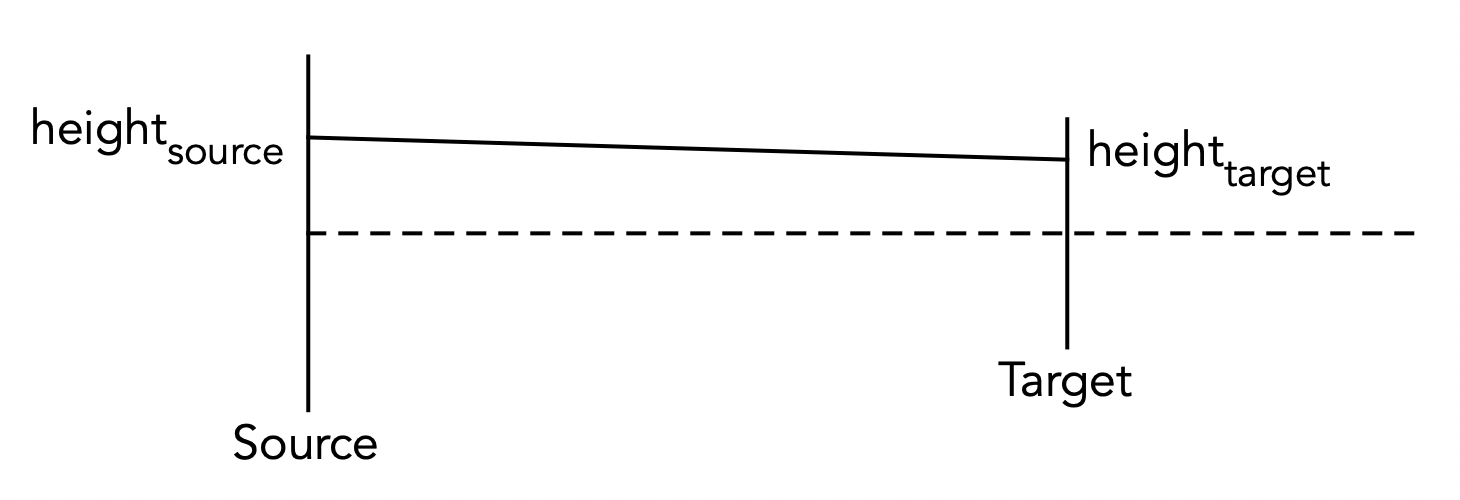

In [9]:
wavelength = 500e-9 
speed_of_light = 3e8

# Coherence time is ≈ λ²/(c⋅Δλ)
coherence_time = wavelength^2 / (speed_of_light*1e-9)
println("Coherence time is ", coherence_time, " s")

Coherence time is 8.333333333333332e-13 s


In [17]:
250/2.8e16/500e-9

1.785714285714286e-8

In [55]:
N_target = 85
N_source = 85



""" Given an integer into the number of emissions points, returns the height in units of ø.

# Arguments
- `i::Integer`: Index into the number of emitters
- `ø::Float`: Diameter of object
- `N::Integer`: Number of emission points
"""
function height_into(i, ø, N)
    
    mid_i = N/2 
    d_i = i-1-mid_i

    fractional_height = d_i / N * ø
    
end

function height_target(i)
    height_into(i, øtarget, N_target)
end

function height_source(i)
    height_into(i, øsource, N_source)
end



# Units meter
øtarget = 250
øsource = 0.5e9/2
Dist = BigFloat(2.8e16) # 3 Lyr
wavelength = 500e-9
speed_of_light = 3e8 # m/s
 
@test height_target(N_target/2+1) == 0
@test height_target(1) == -øtarget/2
@test height_source(1) == -øsource/2


println(height_target(1))
println(height_source(1))

println("Target has an angular diameter of ", Float64(øtarget/Dist))


function sim_scene(do_plot=false)
    results = zeros(ComplexF64,N_target,N_source)
    ϕ_source = rand(Uniform(0,2π), N_source);
    #ϕ_source = zeros(N_source);

    Flux = 1e8 # photon / m^2 / s^2
    Dₜₑₗ = 1
    Aₜₑₗ = π * (Dₜₑₗ/2)^2
    tₑₓₚ = 1e-6

    Flux_per_Scene = Flux * Aₜₑₗ * tₑₓₚ / N_source

    Threads.@threads for is in 1:N_source # These are the emitters
        if abs(height_source(is)) < 0.0øsource 
            continue
        end

        for it in 1:N_target # These are the target
            dh = height_target(it) - height_source(is) 
            path_length = sqrt(dh^2 + Dist^2) 
            total_phase = path_length / wavelength
            n_waves = Float64(total_phase - round(total_phase)) 

            results[it,is] = Flux_per_Scene * exp(1im * (2π * n_waves + ϕ_source[is]))

        end
    end

    y=abs.(sum(results, dims=2))
    y = y / mean(y)

    if do_plot
        plot(y)
    end

    return y
end

function sim_to_bw(τₒ, τₜ)
"""
    τₒ is time of an observation, usually something like 1 µs or faster
    τₜ is the coherence time, usually like 0.1 ps
"""

    scene = sim_scene()

    N_sims = trunc(Int, τₒ / τₜ) # Number of simulations

    results = zeros(size(scene)..., N_sims)

    println(size(results))

    results[:,:,1] = scene

    Threads.@threads for i in 2:N_sims
        scene = sim_scene()
        results[:,:,i] = scene
    end
    
    results

end

res = sim_to_bw(1e-8, 1e-12);


-125.0
-1.25e8
Target has an angular diameter of 8.92857142857143e-15


(85, 1, 10000)


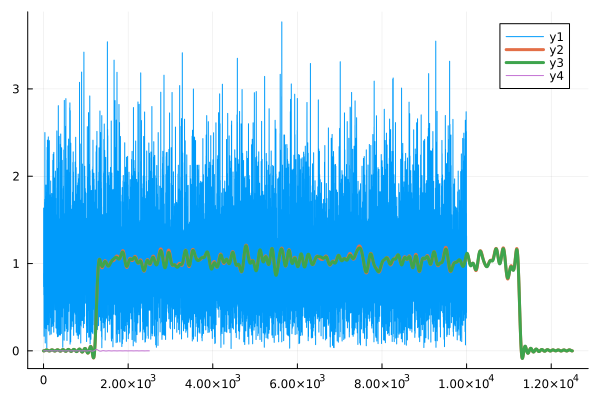

In [56]:
M = Int(1e6)
data = res[1,1,:]

x_filt = LinRange(-1e-10, 1e-10, trunc(Int, length(data)/4))
k = 6e11*x_filt

filter = sin.(k) ./ k
filter = filter ./ sum(filter)

c = DSP.conv(filter, data);

data2 = res[2,1,:]
c2 = DSP.conv(filter, data2)

plot(data)
plot!(c, linewidth=3)
plot!(c2, linewidth=3)
plot!(filter)

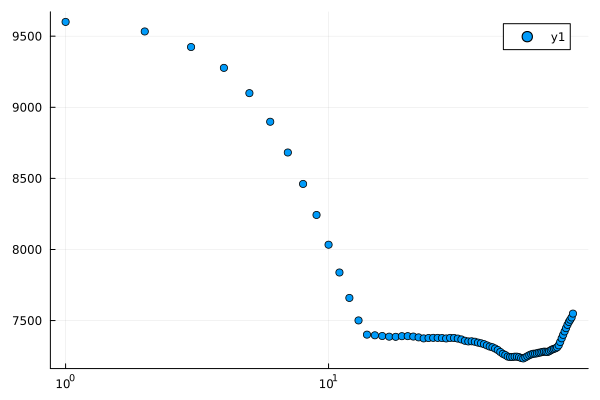

In [57]:

function plot_corrs(dat)

    n_sites_x, n_sites_y, N = size(dat)

    xcd = zeros(n_sites_x)
    c = dat[1,1,200:800]
    c = dat[1,1,2000:9000]
    for i in 1:n_sites_x
        c2 = dat[i,1,:]
        v = DSP.xcorr(c,c2)
        val, pos = findmax(v)
        xcd[i] = val
    end

    xcd
end

r = plot_corrs(res);
scatter(r, xaxis=:log, kind="scatter")


In [133]:
a,b,c = size(res)

(85, 1, 1000)

In [6]:
x_filt = LinRange(-1e-10, 1e-10, length(data))


1000-element LinRange{Float64, Int64}:
 -1.0e-10,-9.97998e-11,-9.95996e-11,…,9.95996e-11,9.97998e-11,1.0e-10

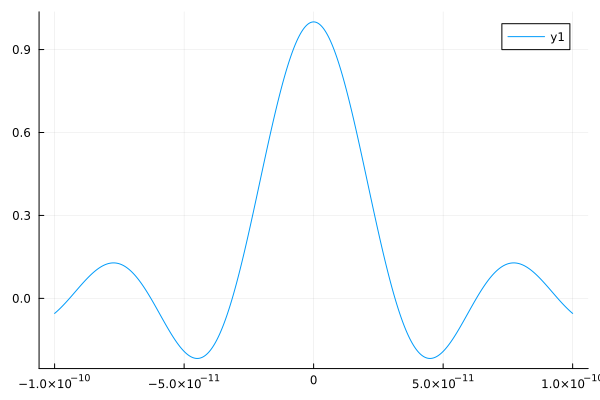

In [50]:
k = 1e11*x_filt
plot(x_filt, sin.(k)./k)

In [44]:
k

100-element LinRange{Float64, Int64}:
 -1.0e-21,-9.79798e-22,-9.59596e-22,…,9.59596e-22,9.79798e-22,1.0e-21